# Reference model - test set: 3 domain features
### MLP architecture as combined AE


In [1]:
import sys
sys.path.append('../Src/')
from data import *
from transfer_learning import *
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
from results import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

Using TensorFlow backend.


In [3]:
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = \
    read_df_with_transfer_learning_subset_fewerDomainFeatures(['age','Temperature','Precipitation3Days'])

In [4]:
print(df_domain_train.shape)
print(df_domain_test.shape)

(4251, 3)
(373, 3)


In [5]:
print('TRAIN:')
print('age:' + str(df_domain_train.loc[:,'age'].mean()))
print('rain:' + str(df_domain_train.loc[:,'Precipitation3Days'].mean()))
print('Tª:' + str(df_domain_train.loc[:,'Temperature'].mean()))
    
print('TEST:')
print('age:' + str(df_domain_test.loc[:,'age'].mean()))
print('rain:' + str(df_domain_test.loc[:,'Precipitation3Days'].mean()))
print('Tª:' + str(df_domain_test.loc[:,'Temperature'].mean()))

TRAIN:
age:9.131498470948012
rain:0.4424182545283462
Tª:69.01096212655845
TEST:
age:9.091152815013405
rain:0.4129758713136729
Tª:69.06434316353888


### Get numpy transfer_learning objects

In [6]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

# MLP (Dense) as encoder combined AE <a name="MLP"></a>

In [27]:
def model(shape_in, shape_out, output_transform, layers_list, activation_fn):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    for s in layers_list:
        net = layers.Dense(s, activation=activation_fn)(net)
    net = layers.Dense(shape_out, activation='linear')(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [28]:
def model_fn():
    m = model(shape_in=3,
              shape_out=717,
              output_transform=None,
              layers_list=[32,16,128,512],
              activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [29]:
latent_space=0
results, modelsMLP = train(model_fn,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>98</b></p>

<b>loss</b>: 3.7733 (min: 3.7709, max: 3.7799)

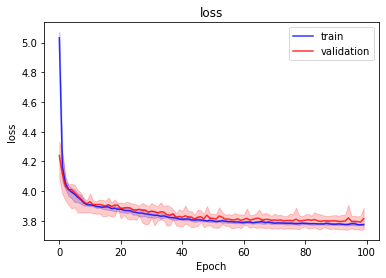

<b>domain_BrayCurtis</b>: 0.4113 (min: 0.4088, max: 0.4123)

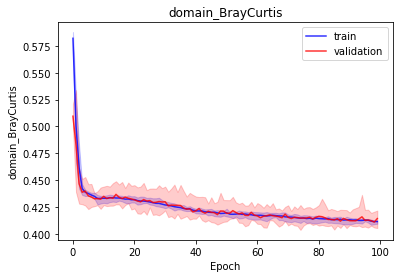

<b>domain_pearson_corr</b>: 0.7269 (min: 0.7248, max: 0.7293)

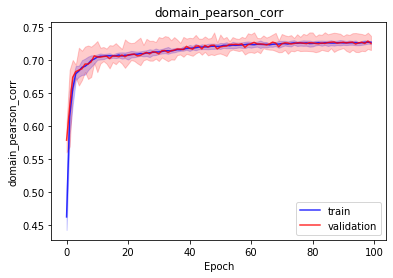

<b>domain_jensen_shannon_divergence</b>: 0.8787 (min: 0.8629, max: 0.8881)

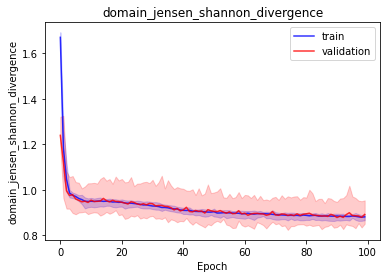

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 3.7732743185036304 | 3.770902114207518 | 3.7798989262300378 |
| domain_BrayCurtis | 0.4113110601902008 | 0.4088129997253418 | 0.4122608006000519 |
| domain_pearson_corr | 0.7269178628921509 | 0.7248016595840454 | 0.7293208837509155 |
| domain_jensen_shannon_divergence | 0.8786566853523254 | 0.8629404902458191 | 0.8880780935287476 |


[('best_lost_epoch', 98),
 ('val_loss', [3.791447271619524, 3.7385774680546353, 3.8353460345949446]),
 ('val_domain_BrayCurtis', [0.4108085, 0.40578628, 0.42051822]),
 ('val_domain_pearson_corr', [0.72867095, 0.716872, 0.7413704]),
 ('val_domain_jensen_shannon_divergence', [0.8784464, 0.83373207, 0.949095])]

In [30]:
print_results(results)

In [31]:
predictions = test_model(modelsMLP, CenterLogRatio, None, data_microbioma_test, data_domain_test)
#save_predictions(predictions, 'experiment_testSet_MLP_3var.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.41337257623672485 | 0.40773341059684753 | 0.4178470969200134 |
| pearson_corr | 0.7206686735153198 | 0.7169762849807739 | 0.7261728644371033 |
| jensen_shannon_divergence | 0.8373594284057617 | 0.819200873374939 | 0.8590947985649109 |
